## Lab 2
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [40]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [41]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')
        
root_path = 'fmnist'
mkdir(root_path)

Directory fmnist already exists!


In [3]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path, 
                                                        train=True, 
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path, 
                                                       train=False, 
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting fmnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to fmnist/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting fmnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to fmnist/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting fmnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to fmnist/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting fmnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to fmnist/FashionMNIST/raw



In [4]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train, 
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)

test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

In [5]:
len(fmnist_dataset_train)

60000

In [6]:
for img, label in train_loader:
    print(img.shape)
    #print(img)
    print(label.shape)
    print(label.size(0))
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])
128


### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [7]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, input_shape),
            nn.ReLU(),
            nn.BatchNorm1d(input_shape, eps = 1e-3, momentum=0.9),
            nn.Dropout(p=0.5),
            nn.Linear(input_shape, num_classes),
            nn.LogSoftmax(-1),
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [8]:
torchsummary.summary(TinyNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 784]         615,440
              ReLU-3                  [-1, 784]               0
       BatchNorm1d-4                  [-1, 784]           1,568
           Dropout-5                  [-1, 784]               0
            Linear-6                   [-1, 10]           7,850
        LogSoftmax-7                   [-1, 10]               0
Total params: 624,858
Trainable params: 624,858
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.03
Params size (MB): 2.38
Estimated Total Size (MB): 2.42
----------------------------------------------------------------


Your experiments come here:

In [10]:
import torch.optim as optim
from sklearn.metrics import accuracy_score
from tqdm.autonotebook import tqdm

model = TinyNeuralNetwork().to(device)
opt = optim.Adam(model.parameters())
loss_func = nn.CrossEntropyLoss()

# Your experiments, training and validation loops here

loss_per_batch = []
n_epoch = 15

for i in range(n_epoch):
    
    model.train()
    correct = 0
    total_instances = 0
    for images, labels in tqdm(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        opt.zero_grad()

        predictions = model.forward(images)
        loss = loss_func.forward(predictions, labels)
        
        loss.backward()
        
        opt.step()    
            
        correct += (predictions.argmax(-1) == labels).float().sum()
        total_instances += len(labels)

        loss_per_batch.append(loss.detach())

    model.eval()
    accuracy = correct / total_instances
    print(accuracy)
    print(loss)

  0%|          | 0/469 [00:00<?, ?it/s]

tensor(0.8227, device='cuda:0')
tensor(0.4091, device='cuda:0', grad_fn=<NllLossBackward0>)


  0%|          | 0/469 [00:00<?, ?it/s]

tensor(0.8479, device='cuda:0')
tensor(0.4557, device='cuda:0', grad_fn=<NllLossBackward0>)


  0%|          | 0/469 [00:00<?, ?it/s]

tensor(0.8532, device='cuda:0')
tensor(0.2898, device='cuda:0', grad_fn=<NllLossBackward0>)


  0%|          | 0/469 [00:00<?, ?it/s]

tensor(0.8595, device='cuda:0')
tensor(0.4577, device='cuda:0', grad_fn=<NllLossBackward0>)


  0%|          | 0/469 [00:00<?, ?it/s]

tensor(0.8616, device='cuda:0')
tensor(0.2536, device='cuda:0', grad_fn=<NllLossBackward0>)


  0%|          | 0/469 [00:00<?, ?it/s]

tensor(0.8673, device='cuda:0')
tensor(0.3765, device='cuda:0', grad_fn=<NllLossBackward0>)


  0%|          | 0/469 [00:00<?, ?it/s]

tensor(0.8679, device='cuda:0')
tensor(0.3591, device='cuda:0', grad_fn=<NllLossBackward0>)


  0%|          | 0/469 [00:00<?, ?it/s]

tensor(0.8693, device='cuda:0')
tensor(0.2855, device='cuda:0', grad_fn=<NllLossBackward0>)


  0%|          | 0/469 [00:00<?, ?it/s]

tensor(0.8708, device='cuda:0')
tensor(0.4150, device='cuda:0', grad_fn=<NllLossBackward0>)


  0%|          | 0/469 [00:00<?, ?it/s]

tensor(0.8732, device='cuda:0')
tensor(0.2027, device='cuda:0', grad_fn=<NllLossBackward0>)


  0%|          | 0/469 [00:00<?, ?it/s]

tensor(0.8735, device='cuda:0')
tensor(0.4123, device='cuda:0', grad_fn=<NllLossBackward0>)


  0%|          | 0/469 [00:00<?, ?it/s]

tensor(0.8790, device='cuda:0')
tensor(0.3394, device='cuda:0', grad_fn=<NllLossBackward0>)


  0%|          | 0/469 [00:00<?, ?it/s]

tensor(0.8787, device='cuda:0')
tensor(0.2809, device='cuda:0', grad_fn=<NllLossBackward0>)


  0%|          | 0/469 [00:00<?, ?it/s]

tensor(0.8809, device='cuda:0')
tensor(0.2930, device='cuda:0', grad_fn=<NllLossBackward0>)


  0%|          | 0/469 [00:00<?, ?it/s]

tensor(0.8831, device='cuda:0')
tensor(0.2158, device='cuda:0', grad_fn=<NllLossBackward0>)


In [13]:
#perfomance
correct = 0
total_instances = 0

with torch.no_grad():
  for images, labels in tqdm(test_loader):
    images, labels = images.to(device), labels.to(device)
    
    predictions = model.forward(images)

    correct += (predictions.argmax(-1) == labels).float().sum()
    total_instances += len(labels)
  accuracy = correct / total_instances
  print(accuracy.item())

  0%|          | 0/40 [00:00<?, ?it/s]

0.8799999952316284


### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

In [42]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, input_shape),
            nn.ReLU(),
            nn.Linear(input_shape, input_shape),
            nn.ReLU(),
            nn.Linear(input_shape, num_classes),
            nn.LogSoftmax(-1),
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [43]:
torchsummary.summary(OverfittingNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 784]         615,440
              ReLU-3                  [-1, 784]               0
            Linear-4                  [-1, 784]         615,440
              ReLU-5                  [-1, 784]               0
            Linear-6                   [-1, 10]           7,850
        LogSoftmax-7                   [-1, 10]               0
Total params: 1,238,730
Trainable params: 1,238,730
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.03
Params size (MB): 4.73
Estimated Total Size (MB): 4.76
----------------------------------------------------------------


In [44]:
from torch.utils.data.sampler import SubsetRandomSampler
dataset_size = len(fmnist_dataset_train)
indices = list(range(dataset_size))
split = int(np.floor(0.2 * dataset_size))
np.random.shuffle(indices)
train_indices = indices[split:]
train_sampler = SubsetRandomSampler(train_indices)
smalltrain_loader = torch.utils.data.DataLoader(fmnist_dataset_train,
                                                batch_size=128,
                                                num_workers=2,
                                                sampler=train_sampler)

In [45]:
model = OverfittingNeuralNetwork().to(device)
opt = optim.Adam(model.parameters())
loss_func = nn.CrossEntropyLoss()

train_losses = []
train_accuracy = []
test_losses = []
test_accuracy = []
n_epoch = 40

for i in range(n_epoch):
    
    model.train()
    correct = 0
    total_instances = 0
    losses = []
    for images, labels in tqdm(smalltrain_loader):
        images = images.to(device)
        labels = labels.to(device)

        opt.zero_grad()

        predictions = model.forward(images)
        loss = loss_func.forward(predictions, labels)
        
        loss.backward()
        
        opt.step()    
   
        losses.append(loss.item())
        correct += (predictions.argmax(-1) == labels).float().sum()
        total_instances += len(labels)

    model.eval()
    train_losses.append(sum(losses) / len(labels)) 
    train_accuracy.append((correct / total_instances).item())
    
    correct = 0
    total_instances = 0
    losses = []
    with torch.no_grad():
      for images, labels in tqdm(test_loader):
        images, labels = images.to(device), labels.to(device)
    
        predictions = model.forward(images)
        loss = loss_func.forward(predictions, labels)

        losses.append(loss.item())
        correct += (predictions.argmax(-1) == labels).float().sum()
        total_instances += len(labels)

      test_losses.append(sum(losses) / len(labels))  
      test_accuracy.append((correct / total_instances).item())

  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

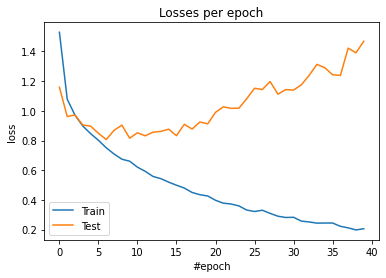

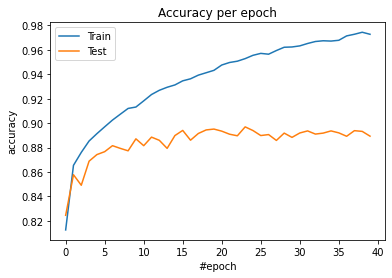

In [46]:
plt.figure()
plt.title("Losses per epoch")
plt.xlabel("#epoch")
plt.ylabel("loss")
plt.plot(train_losses, label='Train')
plt.plot(test_losses, label='Test')
plt.legend()
plt.show()

plt.figure()
plt.title("Accuracy per epoch")
plt.xlabel("#epoch")
plt.ylabel("accuracy")
plt.plot(train_accuracy, label='Train')
plt.plot(test_accuracy, label='Test')
plt.legend()
plt.show()

### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results. 

In [50]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, input_shape),
            nn.ReLU(),
            nn.BatchNorm1d(input_shape, eps = 1e-3, momentum=0.9),
            nn.Dropout(p=0.5),
            nn.Linear(input_shape, input_shape),
            nn.ReLU(),
            nn.BatchNorm1d(input_shape, eps = 1e-3, momentum=0.9),
            nn.Dropout(p=0.5),
            nn.Linear(input_shape, num_classes),
            nn.LogSoftmax(-1),
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [51]:
torchsummary.summary(FixedNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 784]         615,440
              ReLU-3                  [-1, 784]               0
       BatchNorm1d-4                  [-1, 784]           1,568
           Dropout-5                  [-1, 784]               0
            Linear-6                  [-1, 784]         615,440
              ReLU-7                  [-1, 784]               0
       BatchNorm1d-8                  [-1, 784]           1,568
           Dropout-9                  [-1, 784]               0
           Linear-10                   [-1, 10]           7,850
       LogSoftmax-11                   [-1, 10]               0
Total params: 1,241,866
Trainable params: 1,241,866
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forw

In [52]:
model = FixedNeuralNetwork().to(device)
opt = optim.Adam(model.parameters())
loss_func = nn.CrossEntropyLoss()

train_losses = []
train_accuracy = []
test_losses = []
test_accuracy = []
n_epoch = 40

for i in range(n_epoch):
    
    model.train()
    correct = 0
    total_instances = 0
    losses = []
    for images, labels in tqdm(smalltrain_loader):
        images = images.to(device)
        labels = labels.to(device)

        opt.zero_grad()

        predictions = model.forward(images)
        loss = loss_func.forward(predictions, labels)
        
        loss.backward()
        
        opt.step()    
   
        losses.append(loss.item())
        correct += (predictions.argmax(-1) == labels).float().sum()
        total_instances += len(labels)

    model.eval()
    train_losses.append(sum(losses) / len(labels)) 
    train_accuracy.append((correct / total_instances).item())
    
    correct = 0
    total_instances = 0
    losses = []
    with torch.no_grad():
      for images, labels in tqdm(test_loader):
        images, labels = images.to(device), labels.to(device)
    
        predictions = model.forward(images)
        loss = loss_func.forward(predictions, labels)

        losses.append(loss.item())
        correct += (predictions.argmax(-1) == labels).float().sum()
        total_instances += len(labels)

      test_losses.append(sum(losses) / len(labels))  
      test_accuracy.append((correct / total_instances).item())

  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

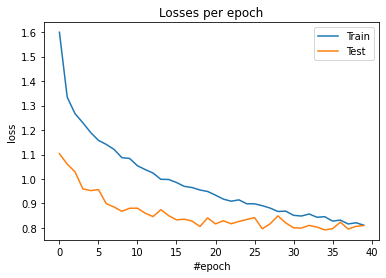

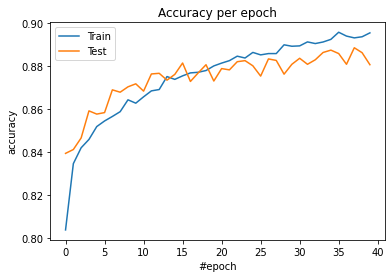

In [53]:
plt.figure()
plt.title("Losses per epoch")
plt.xlabel("#epoch")
plt.ylabel("loss")
plt.plot(train_losses, label='Train')
plt.plot(test_losses, label='Test')
plt.legend()
plt.show()

plt.figure()
plt.title("Accuracy per epoch")
plt.xlabel("#epoch")
plt.ylabel("accuracy")
plt.plot(train_accuracy, label='Train')
plt.plot(test_accuracy, label='Test')
plt.legend()
plt.show()

### Conclusions:
On large number of epochs DL model without batchnorm and dropout can easily overfit, so it is necessarily to add those layers in a model. 